In [30]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Estimate the variance factors for the linear mixed-effects models

## Incumbent analysis

### Data wrangling

In [3]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [4]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])
len(knowwho_profiles)

1204

In [5]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [7]:
# grab a set of tweets from at least 16 weeks before election dates
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])
pilot_data = pd.DataFrame()
i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date() - pd.Timedelta(days=16 * 7))
    ]
    pilot_data = pd.concat([pilot_data, candidate_tweets])
    i += 1

pilot_data = pilot_data.reset_index()

0/1204
100/1204
200/1204
300/1204
400/1204
500/1204
600/1204
700/1204
800/1204
900/1204
1000/1204
1100/1204
1200/1204


In [8]:
knowwho_profiles.head(3)

,,author_id,description,created_at,followers_count,following_count,tweet_count,INCUMBENT,STATEABBR,LEVEL,CHAMBER,DISTRICT,RACE,ETHNICITY,GENDER,PARTY,name
handle,ELECTIONDATE,,,,,,,,,,,,,,,,
carlforalabama,2022-05-24,2237925464,"Husband, father, and small businessman. Offici...",2013-12-09 16:53:13+00:00,2979.0,1296.0,822.0,Y,AL,FL,FH,1.0,US Representative,White/Caucasian,Male,R,Jerry L. Carl
phyllisdhhall,2022-05-24,4856325569,Feminist💯. Wife. Mother. Activist. Justice War...,2016-01-28 06:36:43+00:00,4646.0,2519.0,2284.0,NaN,AL,FL,FH,2.0,US Representative,Black/African American,Female,D,Phyllis Harvey-Hall
repbarrymoore,2022-05-24,1339006078688825344,U.S. Representative for #AL02. Do justly. Love...,2020-12-16 00:35:16+00:00,11869.0,734.0,2404.0,Y,AL,FL,FH,2.0,US Representative,White/Caucasian,Male,R,Barry Moore


In [9]:
pilot_data.head(3)

,index,id,author_id,handle,created_at,retweeted,quoted,reply,has_url,tweet_length,avg_belief_score,avg_fact_score,NG_score,NG_unreliable
0,1005836,1483613324076109826,2237925464,carlforalabama,2022-01-19 01:32:35+00:00,False,True,False,True,39,NaN,NaN,NaN,NaN
1,1005837,1483287960212619270,2237925464,carlforalabama,2022-01-18 03:59:42+00:00,False,False,False,True,64,NaN,NaN,80.0,0.0
2,1005838,1482427170546929673,2237925464,carlforalabama,2022-01-15 18:59:14+00:00,False,False,False,False,106,-0.141208,-0.096294,NaN,NaN


In [10]:
pilot_data = pd.merge(
    pilot_data,
    knowwho_profiles[["author_id", "INCUMBENT", "PARTY"]],
    how="left",
    left_on="author_id",
    right_on="author_id"
)

In [11]:
pilot_data = pilot_data.rename(columns={"INCUMBENT":"T"})
pilot_data["T"] = pilot_data["T"].fillna(0)
pilot_data["T"] = pilot_data["T"].replace({"Y":1})

/tmp/ipykernel_876907/2286635500.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pilot_data["T"] = pilot_data["T"].replace({"Y":1})


In [12]:
pilot_data.head(3)

,index,id,author_id,handle,created_at,retweeted,quoted,reply,has_url,tweet_length,avg_belief_score,avg_fact_score,NG_score,NG_unreliable,T,PARTY
0,1005836,1483613324076109826,2237925464,carlforalabama,2022-01-19 01:32:35+00:00,False,True,False,True,39,NaN,NaN,NaN,NaN,1,R
1,1005837,1483287960212619270,2237925464,carlforalabama,2022-01-18 03:59:42+00:00,False,False,False,True,64,NaN,NaN,80.0,0.0,1,R
2,1005838,1482427170546929673,2237925464,carlforalabama,2022-01-15 18:59:14+00:00,False,False,False,False,106,-0.141208,-0.096294,NaN,NaN,1,R


In [13]:
pilot_data = pilot_data[["avg_belief_score", "PARTY", "T", "author_id"]].dropna()

In [14]:
len(pilot_data)

83185

In [111]:
len(pilot_data["author_id"].unique())

850

In [112]:
pilot_data.drop_duplicates(subset=["author_id"])["PARTY"].value_counts()

PARTY
R    436
D    414
Name: count, dtype: int64

In [113]:
pilot_data.drop_duplicates(subset=["author_id"])["T"].value_counts()

T
0    594
1    256
Name: count, dtype: int64

### Estimate variance factors

In [15]:
model = smf.mixedlm(
    "avg_belief_score ~ 1 + PARTY * T", 
    pilot_data, 
    groups=pilot_data["author_id"],
)
result = model.fit()
print(result.summary())

/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_belief_score
No. Observations: 83185   Method:             REML            
No. Groups:       850     Scale:              0.0124          
Min. group size:  1       Log-Likelihood:     63703.2491      
Max. group size:  3432    Converged:          Yes             
Mean group size:  97.9                                        
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        0.005     0.003   1.464  0.143  -0.002   0.011
PARTY[T.R]      -0.013     0.004  -2.864  0.004  -0.021  -0.004
T               -0.005     0.006  -0.821  0.412  -0.016   0.006
PARTY[T.R]:T     0.009     0.008   1.128  0.259  -0.007   0.026
Group Var        0.002     0.001                               



In [16]:
result.cov_re

,Group
Group,0.002295


In [18]:
result.scale

0.01237839803161637

### Estimate confidence interval of random intercept variance

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [68]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [70]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [100]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [107]:
likelihood_cuttoff

63701.32914703833

In [108]:
likev[:, 0][first_index]

0.002057253892188398

In [109]:
likev[:, 0][second_index]

0.0025929587836751667

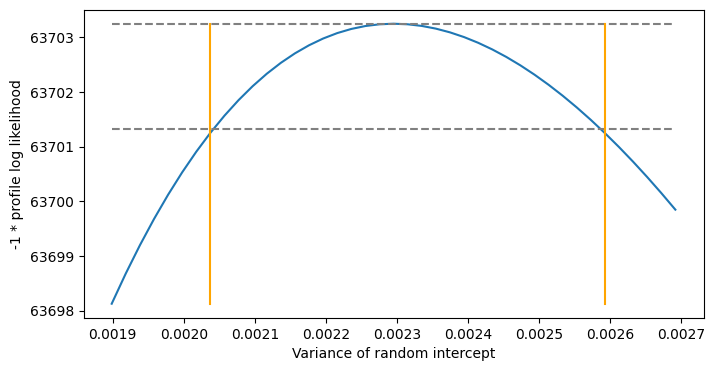

In [106]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
        pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_belief_score ~ 1 + PARTY * T", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)

In [128]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00989173, 0.015717  ])

## Vote share analysis

### Data wrangling

In [134]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [135]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])
len(knowwho_profiles)

1204

In [131]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [132]:
fname = "primaries_for_margin_research_RW_JL.csv"
margins = pd.read_csv(Path(src, fname), parse_dates=["ELECTIONDATE"], dayfirst=True)
margins = margins.drop(columns="COMPLETE")
margins = margins.dropna(subset=["handle"])
margins = margins.set_index(["handle", "ELECTIONDATE"])
margins.head(3)

,,name,PARTY,STATEABBR,RACE,DISTRICT,VOTE_SHARE,NOTES,NONPARTISAN_PRIMARY,DISTRICT_CORR,STATE_CORR,RUNOFF_PERC,RANKED_CHOICE_VOTING
handle,ELECTIONDATE,,,,,,,,,,,,
carlforalabama,2022-05-24,Jerry L. Carl,R,AL,US Representative,1.0,NaN,C,NaN,NaN,NaN,NaN,NaN
terellanderson,2022-05-24,Reginald Terell Anderson,D,AL,US Representative,2.0,NaN,WD,NaN,NaN,NaN,NaN,NaN
phyllisdhhall,2022-05-24,Phyllis Harvey-Hall,D,AL,US Representative,2.0,68.8,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
# add ranked-choice voting entries, notes, non-partisan election entries,
# percentages from runoff votes, and vote shares
knowwho_profiles["RANKED_CHOICE_VOTING"] = np.nan
knowwho_profiles["NOTES"] = np.nan
knowwho_profiles["NOTES"] = knowwho_profiles["NOTES"].astype(object)
knowwho_profiles["NONPARTISAN_PRIMARY"] = np.nan
knowwho_profiles["RUNOFF_PERC"] = np.nan
knowwho_profiles["VOTE_SHARE"] = np.nan

for handle, electiondate in knowwho_profiles.index:
    knowwho_profiles.loc[(handle, electiondate), "RANKED_CHOICE_VOTING"] = \
        margins.loc[(handle, electiondate), "RANKED_CHOICE_VOTING"].values[0]
    knowwho_profiles.loc[(handle, electiondate), "NOTES"] = \
        margins.loc[(handle, electiondate), "NOTES"].values[0]
    knowwho_profiles.loc[(handle, electiondate), "NONPARTISAN_PRIMARY"] = \
        margins.loc[(handle, electiondate), "NONPARTISAN_PRIMARY"].values[0]
    knowwho_profiles.loc[(handle, electiondate), "VOTE_SHARE"] = \
        margins.loc[(handle, electiondate), "VOTE_SHARE"].values[0]

In [137]:
del margins

In [138]:
# remove all candidates that don't have a vote share
knowwho_profiles = knowwho_profiles.dropna(subset=["VOTE_SHARE"])

# remove all candidates that got a vote share of 100%
knowwho_profiles = knowwho_profiles[knowwho_profiles["VOTE_SHARE"] != 100]

In [140]:
# grab a set of tweets from at least 16 weeks before election dates
pilot_data = pd.DataFrame()
i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date() - pd.Timedelta(days=16 * 7))
    ]
    pilot_data = pd.concat([pilot_data, candidate_tweets])
    i += 1

pilot_data = pilot_data.reset_index()

0/797
100/797
200/797
300/797
400/797
500/797
600/797
700/797


In [143]:
pilot_data = pd.merge(
    pilot_data,
    knowwho_profiles[["author_id", "VOTE_SHARE", "PARTY"]],
    how="left",
    left_on="author_id",
    right_on="author_id"
)

In [144]:
pilot_data.head(3)

,index,id,author_id,handle,created_at,retweeted,quoted,reply,has_url,tweet_length,avg_belief_score,avg_fact_score,NG_score,NG_unreliable,VOTE_SHARE,PARTY
0,1003470,1484991325137215490,4856325569,phyllisdhhall,2022-01-22 20:48:16+00:00,False,False,True,False,152,0.076789,0.076472,NaN,NaN,68.8,D
1,1003471,1485473792830984197,4856325569,phyllisdhhall,2022-01-24 04:45:25+00:00,False,False,True,False,170,0.033488,-0.028163,NaN,NaN,68.8,D
2,1003488,1486169138611593217,4856325569,phyllisdhhall,2022-01-26 02:48:28+00:00,False,False,True,False,185,NaN,NaN,NaN,NaN,68.8,D


In [145]:
pilot_data = pilot_data[["avg_belief_score", "PARTY", "VOTE_SHARE", "author_id"]].dropna()

In [146]:
len(pilot_data)

51418

In [147]:
len(pilot_data["author_id"].unique())

571

In [148]:
pilot_data.drop_duplicates(subset=["author_id"])["PARTY"].value_counts()

PARTY
R    309
D    262
Name: count, dtype: int64

### Estimate variance factors

In [149]:
model = smf.mixedlm(
    "avg_belief_score ~ 1 + PARTY * VOTE_SHARE", 
    pilot_data, 
    groups=pilot_data["author_id"],
)
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: avg_belief_score
No. Observations:   51418   Method:             REML            
No. Groups:         571     Scale:              0.0133          
Min. group size:    1       Log-Likelihood:     37508.8440      
Max. group size:    1568    Converged:          Yes             
Mean group size:    90.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.003    0.005  0.596 0.551 -0.007  0.013
PARTY[T.R]            -0.011    0.007 -1.486 0.137 -0.025  0.003
VOTE_SHARE             0.000    0.000  0.085 0.932 -0.000  0.000
PARTY[T.R]:VOTE_SHARE -0.000    0.000 -0.008 0.994 -0.000  0.000
Group Var              0.002    0.001                           



/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [150]:
result.cov_re

,Group
Group,0.001967


In [151]:
result.scale

0.013305959951221604

### Estimate confidence interval of random intercept variance

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [152]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [153]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [154]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [155]:
likelihood_cuttoff

37506.92396988608

In [156]:
likev[:, 0][first_index]

0.0017093953832548999

In [157]:
likev[:, 0][second_index]

0.002284550428498427

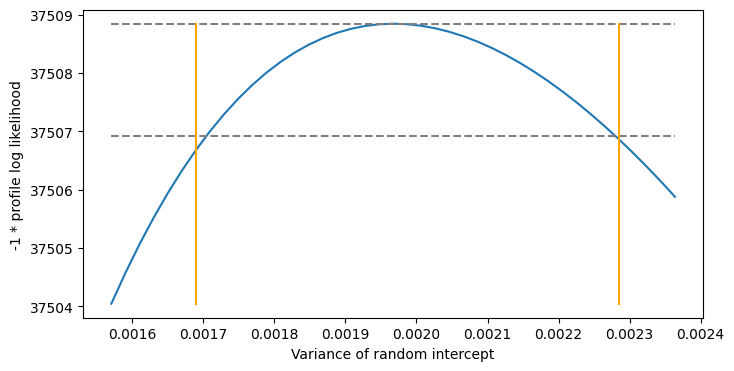

In [158]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
        pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_belief_score ~ 1 + PARTY * VOTE_SHARE", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)

In [162]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00988619, 0.01754056])

## Election analysis

### Data wrangling

In [219]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [220]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])
len(knowwho_profiles)

1204

In [221]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [222]:
# grab a set of tweets from at least 16 weeks before election dates and at least
# 16 weeks after election dates
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])
pilot_data = pd.DataFrame()
i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets_before = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date() - pd.Timedelta(days=16 * 7))
    ].copy()
    candidate_tweets_after = candidate_tweets[
        (candidate_tweets["created_at"].dt.date >= electiondate.date() + pd.Timedelta(days=16 * 7))
    ].copy()

    candidate_tweets_before["E"] = 0
    candidate_tweets_after["E"] = 1
    pilot_data = pd.concat([pilot_data, candidate_tweets_before, candidate_tweets_after])
    i += 1

pilot_data = pilot_data.reset_index()

0/1204
100/1204
200/1204
300/1204
400/1204
500/1204
600/1204
700/1204
800/1204
900/1204
1000/1204
1100/1204
1200/1204


In [223]:
pilot_data = pd.merge(
    pilot_data,
    knowwho_profiles[["author_id", "PARTY"]],
    how="left",
    left_on="author_id",
    right_on="author_id"
)

pilot_data.head(3)

,index,id,author_id,handle,created_at,retweeted,quoted,reply,has_url,tweet_length,avg_belief_score,avg_fact_score,NG_score,NG_unreliable,E,PARTY
0,1005836,1483613324076109826,2237925464,carlforalabama,2022-01-19 01:32:35+00:00,False,True,False,True,39,NaN,NaN,NaN,NaN,0,R
1,1005837,1483287960212619270,2237925464,carlforalabama,2022-01-18 03:59:42+00:00,False,False,False,True,64,NaN,NaN,80.0,0.0,0,R
2,1005838,1482427170546929673,2237925464,carlforalabama,2022-01-15 18:59:14+00:00,False,False,False,False,106,-0.141208,-0.096294,NaN,NaN,0,R


In [224]:
pilot_data = pilot_data[["avg_belief_score", "avg_fact_score", "PARTY", "E", "author_id"]].dropna()

In [225]:
len(pilot_data)

277943

In [226]:
len(pilot_data["author_id"].unique())

1026

In [227]:
pilot_data.drop_duplicates(subset=["author_id"])["PARTY"].value_counts()

PARTY
R    539
D    487
Name: count, dtype: int64

In [228]:
pilot_data[pilot_data["E"] == 1].drop_duplicates(subset=["author_id"])["PARTY"].value_counts()

PARTY
R    459
D    434
Name: count, dtype: int64

In [229]:
pilot_data["E"].value_counts()

E
1    194758
0     83185
Name: count, dtype: int64

### Estimate variance factors for belief-speaking

In [176]:
model = smf.mixedlm(
    "avg_belief_score ~ 1 + PARTY * E", 
    pilot_data, 
    groups=pilot_data["author_id"],
    re_formula="1 + E"
)
result = model.fit()
print(result.summary())

/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_belief_score
No. Observations: 277943  Method:             REML            
No. Groups:       1026    Scale:              0.0119          
Min. group size:  1       Log-Likelihood:     219246.1108     
Max. group size:  6467    Converged:          Yes             
Mean group size:  270.9                                       
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        0.000     0.003   0.188  0.851  -0.005   0.006
PARTY[T.R]      -0.008     0.004  -2.229  0.026  -0.015  -0.001
E               -0.008     0.002  -3.442  0.001  -0.013  -0.004
PARTY[T.R]:E     0.006     0.003   1.716  0.086  -0.001   0.013
Group Var        0.003     0.001                               
Group x E Cov   -0.000     0.001                            

In [177]:
result.cov_re

,Group,E
Group,0.002531,-0.000195
E,-0.000195,0.001491


In [178]:
result.scale

0.011907478206024906

### Estimate confidence interval of random intercept variance for belief-speaking

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [179]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [180]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [181]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [182]:
likelihood_cuttoff

219244.19078320978

In [183]:
likev[:, 0][first_index]

0.002251390488212639

In [184]:
likev[:, 0][second_index]

0.002869925239282561

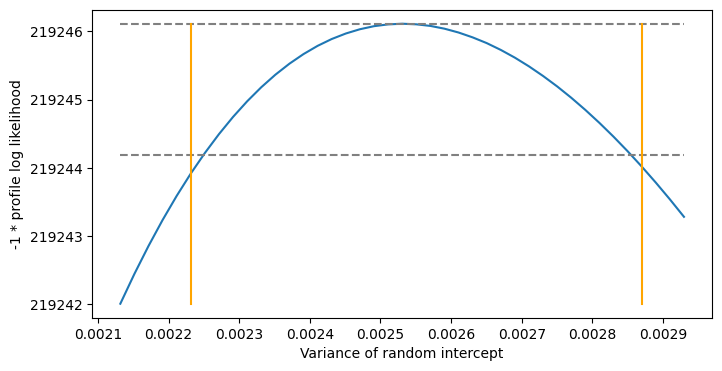

In [185]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of random slope variance for belief-speaking

In [186]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(1, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [187]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [188]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [189]:
likelihood_cuttoff

219244.19078320978

In [190]:
likev[:, 0][first_index]

0.0012717469694225514

In [191]:
likev[:, 0][second_index]

0.001770983639715129

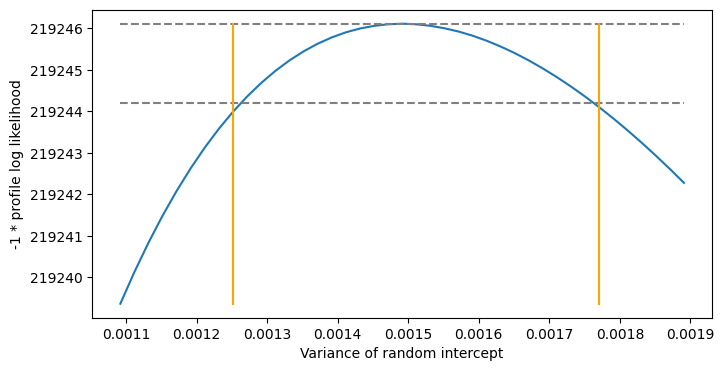

In [192]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance and slope/intercept covariance for belief-speaking

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
covariances = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
    
    pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_belief_score ~ 1 + PARTY * E", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
        re_formula="1 + E"
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)
    covariances.append(result_bootstrapped.cov_re.loc["Group", "E"])

In [206]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00992597, 0.01459067])

In [207]:
np.percentile(covariances, [2.5, 97.5])

array([-8.61140478e-04, -7.46629383e-05])

### Estimate variance factors for fact-speaking

In [230]:
model = smf.mixedlm(
    "avg_fact_score ~ 1 + PARTY * E", 
    pilot_data, 
    groups=pilot_data["author_id"],
    re_formula="1 + E"
)
result = model.fit()
print(result.summary())

/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_fact_score
No. Observations: 277943  Method:             REML          
No. Groups:       1026    Scale:              0.0094        
Min. group size:  1       Log-Likelihood:     251864.6867   
Max. group size:  6467    Converged:          Yes           
Mean group size:  270.9                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.008    0.002  3.678 0.000  0.004  0.013
PARTY[T.R]        -0.013    0.003 -4.079 0.000 -0.019 -0.007
E                 -0.013    0.002 -6.072 0.000 -0.017 -0.009
PARTY[T.R]:E       0.008    0.003  2.610 0.009  0.002  0.014
Group Var          0.002    0.001                           
Group x E Cov     -0.000    0.001                           
E Var              0.001    0.001   

In [231]:
result.cov_re

,Group,E
Group,0.001828,-0.000106
E,-0.000106,0.001131


In [232]:
result.scale

0.009419212941440758

### Estimate confidence interval of random intercept variance for fact-speaking

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [233]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [234]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [235]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [236]:
likelihood_cuttoff

251862.7666579768

In [237]:
likev[:, 0][first_index]

0.0016286858286653813

In [238]:
likev[:, 0][second_index]

0.002067668110258844

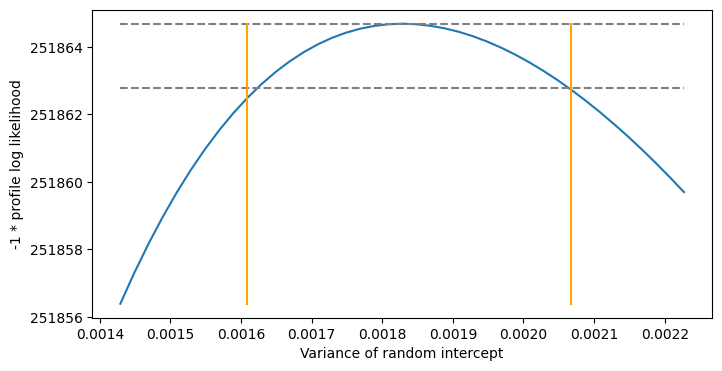

In [239]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of random slope variance for fact-speaking

In [240]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(1, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [241]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [242]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [243]:
likelihood_cuttoff

251862.7666579768

In [244]:
likev[:, 0][first_index]

0.0009716933782071913

In [245]:
likev[:, 0][second_index]

0.0013511188188095422

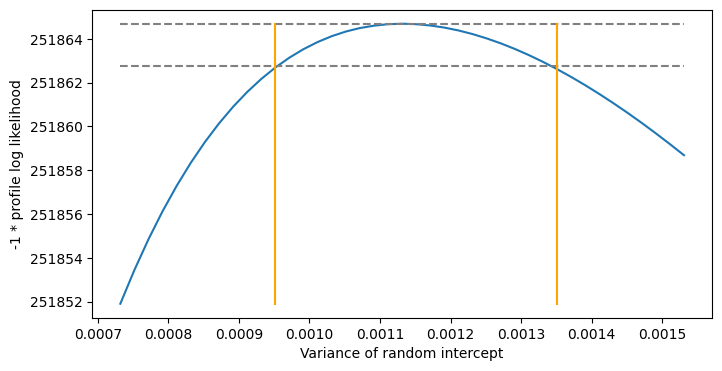

In [246]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance and slope/intercept covariance for fact-speaking

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
covariances = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
    
    pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_fact_score ~ 1 + PARTY * E", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
        re_formula="1 + E"
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)
    covariances.append(result_bootstrapped.cov_re.loc["Group", "E"])

In [250]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00827022, 0.01143926])

In [251]:
np.percentile(covariances, [2.5, 97.5])

array([-0.00069625,  0.00010319])